<a href="https://colab.research.google.com/github/victorm0202/curso_ML_metagenomica/blob/main/notebooks/2a_log_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![figure](https://drive.google.com/uc?export=view&id=1aBthHd8htwQd89eWTOSDaDClpisx5FsA)

<center> Estadística y computación para metagenómica<center>

<center> Víctor Muñiz Sánchez <center>
<center> Junio 2023 <center>

# Logistic Regression 

## Ejemplo: Extramarital Affairs dataset

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import logit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
# por esta ocasion, no pongo las graficas inline, para poder mostrarlas en un slide aparte...
#%matplotlib inline
plt.ioff() # pongo Interactive Mode Off
#plt.style.use('seaborn') 

### Los datos

In [2]:
print(sm.datasets.fair.SOURCE)


Fair, Ray. 1978. "A Theory of Extramarital Affairs," `Journal of Political
Economy`, February, 45-61.

The data is available at http://fairmodel.econ.yale.edu/rayfair/pdf/2011b.htm



In [3]:
print( sm.datasets.fair.NOTE)

::

    Number of observations: 6366
    Number of variables: 9
    Variable name definitions:

        rate_marriage   : How rate marriage, 1 = very poor, 2 = poor, 3 = fair,
                        4 = good, 5 = very good
        age             : Age
        yrs_married     : No. years married. Interval approximations. See
                        original paper for detailed explanation.
        children        : No. children
        religious       : How relgious, 1 = not, 2 = mildly, 3 = fairly,
                        4 = strongly
        educ            : Level of education, 9 = grade school, 12 = high
                        school, 14 = some college, 16 = college graduate,
                        17 = some graduate school, 20 = advanced degree
        occupation      : 1 = student, 2 = farming, agriculture; semi-skilled,
                        or unskilled worker; 3 = white-colloar; 4 = teacher
                        counselor social worker, nurse; artist, writers;
          

In [4]:
dta = sm.datasets.fair.load_pandas().data
dta

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666
...,...,...,...,...,...,...,...,...,...
6361,5.0,32.0,13.0,2.0,3.0,17.0,4.0,3.0,0.000000
6362,4.0,32.0,13.0,1.0,1.0,16.0,5.0,5.0,0.000000
6363,5.0,22.0,2.5,0.0,2.0,14.0,3.0,1.0,0.000000
6364,5.0,32.0,6.0,1.0,3.0,14.0,3.0,4.0,0.000000


In [5]:
print(dta.describe())

       rate_marriage          age  yrs_married     children    religious  \
count    6366.000000  6366.000000  6366.000000  6366.000000  6366.000000   
mean        4.109645    29.082862     9.009425     1.396874     2.426170   
std         0.961430     6.847882     7.280120     1.433471     0.878369   
min         1.000000    17.500000     0.500000     0.000000     1.000000   
25%         4.000000    22.000000     2.500000     0.000000     2.000000   
50%         4.000000    27.000000     6.000000     1.000000     2.000000   
75%         5.000000    32.000000    16.500000     2.000000     3.000000   
max         5.000000    42.000000    23.000000     5.500000     4.000000   

              educ   occupation  occupation_husb      affairs  
count  6366.000000  6366.000000      6366.000000  6366.000000  
mean     14.209865     3.424128         3.850141     0.705374  
std       2.178003     0.942399         1.346435     2.203374  
min       9.000000     1.000000         1.000000     0.0000

### Construimos la variable dependiente (binaria)

In [6]:
dta['affair'] = (dta['affairs'] > 0).astype(int)
dta['affair']

0       1
1       1
2       1
3       1
4       1
       ..
6361    0
6362    0
6363    0
6364    0
6365    0
Name: affair, Length: 6366, dtype: int64

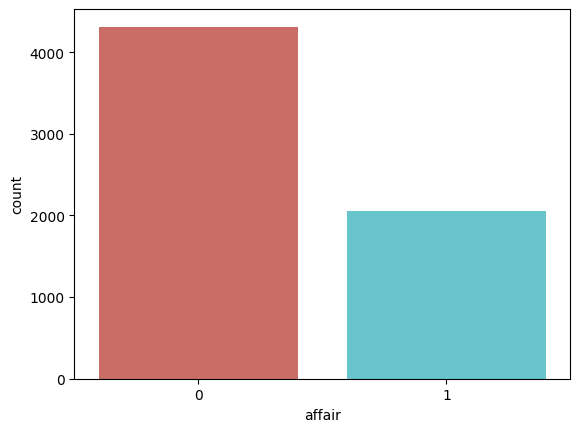

In [7]:
sns.countplot(x='affair',data=dta, palette='hls')
plt.show()

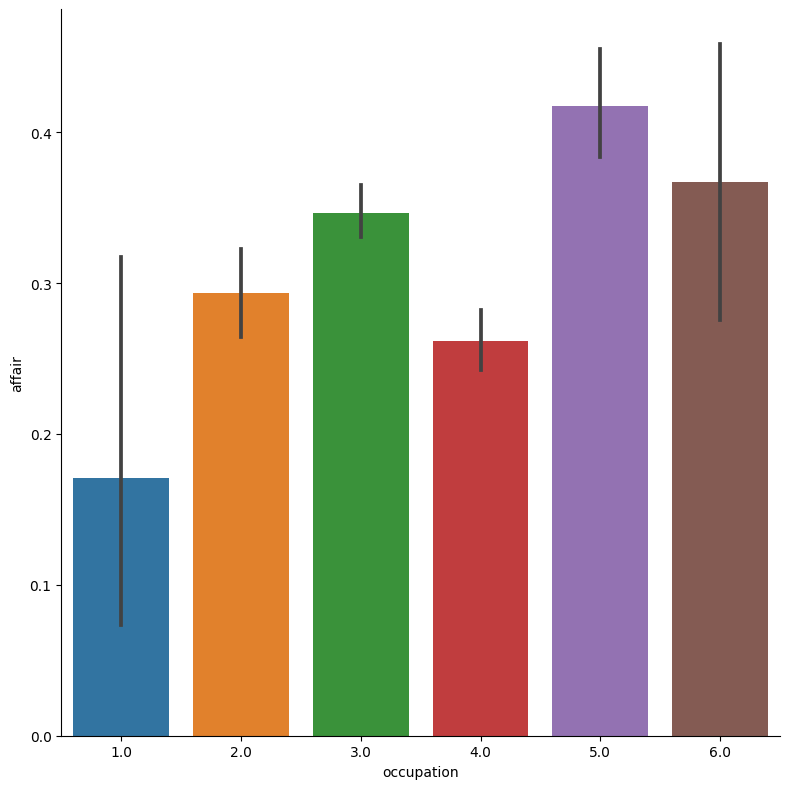

In [8]:
sns.catplot(x="occupation", y="affair", data=dta, kind="bar", height = 8)
plt.show()

### El modelo de regresión logística

Hacemos una decodificación (one-hot encoding) de las variables categóricas mediante variables `dummy`

In [9]:
data = dta
cat_vars = ['rate_marriage', 'religious','educ', 'occupation', 'occupation_husb']

# Una forma de hacerlo es mediante Pandas...
cat_dummy = pd.get_dummies(data['rate_marriage'], prefix='rate_marriage', drop_first=True)
cat_dummy

,rate_marriage_2.0,rate_marriage_3.0,rate_marriage_4.0,rate_marriage_5.0
0,0,1,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,1,0
4,0,0,0,1
...,...,...,...,...
6361,0,0,0,1
6362,0,0,1,0
6363,0,0,0,1
6364,0,0,0,1


Otra forma es mediante las estructuras de datos para modelos de `patsy`.

Recomendable para modelos estadísticos donde se usan matrices de diseño

In [10]:
from patsy import dmatrices

data = dta
cat_vars = ['rate_marriage', 'religious','educ', 'occupation', 'occupation_husb']

y, X = dmatrices('affair ~ C(occupation) + C(educ) + C(occupation_husb)'
                 '+ C(rate_marriage) + age + yrs_married + children'
                 '+ C(religious)', data, return_type = 'dataframe')


In [11]:
X

,Intercept,C(occupation)[T.2.0],C(occupation)[T.3.0],C(occupation)[T.4.0],C(occupation)[T.5.0],C(occupation)[T.6.0],C(educ)[T.12.0],C(educ)[T.14.0],C(educ)[T.16.0],C(educ)[T.17.0],...,C(rate_marriage)[T.2.0],C(rate_marriage)[T.3.0],C(rate_marriage)[T.4.0],C(rate_marriage)[T.5.0],C(religious)[T.2.0],C(religious)[T.3.0],C(religious)[T.4.0],age,yrs_married,children
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,32.0,9.0,3.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,27.0,13.0,3.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,22.0,2.5,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,37.0,16.5,4.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,27.0,9.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6361,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,32.0,13.0,2.0
6362,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,32.0,13.0,1.0
6363,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,22.0,2.5,0.0
6364,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,32.0,6.0,1.0


### Creamos conjunto de datos de entrenamiento y prueba

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, pd.Series.ravel(y), test_size=0.3, random_state=0)

### Regresión logística mediante un enfoque de modelos estadísticos

In [13]:
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit(method='newton')
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.540886
         Iterations 6
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.142      
Dependent Variable:    y                  AIC:                4872.3800  
Date:                  2023-05-04 16:32   BIC:                5038.8322  
No. Observations:      4456               Log-Likelihood:     -2410.2    
Df Model:              25                 LL-Null:            -2808.3    
Df Residuals:          4430               LLR p-value:        7.8883e-152
Converged:             1.0000             Scale:              1.0000     
No. Iterations:        6.0000                                            
-------------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
Intercept                  0.2497   0.85

Métricas de evaluación

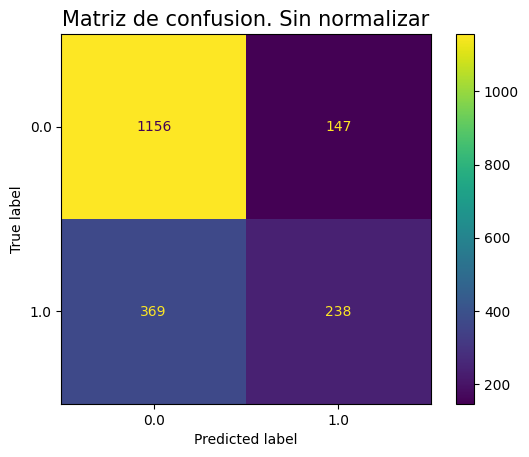

In [14]:
y_pred1 = result.predict(X_test)
y_pred1 = [0 if x < 0.5 else 1 for x in y_pred1]

#confusion_matrix = metrics.confusion_matrix(y_test, y_pred1)
disp1 = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred1)
disp1.ax_.set_title('Matriz de confusion. Sin normalizar',{'fontsize':15})
plt.show()

In [15]:
print(metrics.classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

         0.0       0.76      0.89      0.82      1303
         1.0       0.62      0.39      0.48       607

    accuracy                           0.73      1910
   macro avg       0.69      0.64      0.65      1910
weighted avg       0.71      0.73      0.71      1910



### Usando `sklearn`

In [16]:
logreg = LogisticRegression(solver='newton-cg', C = 1e9)
logreg.fit(X_train, y_train)

LogisticRegression(C=1000000000.0, solver='newton-cg')

In [17]:
y_pred2 = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.73


Métricas de evaluación

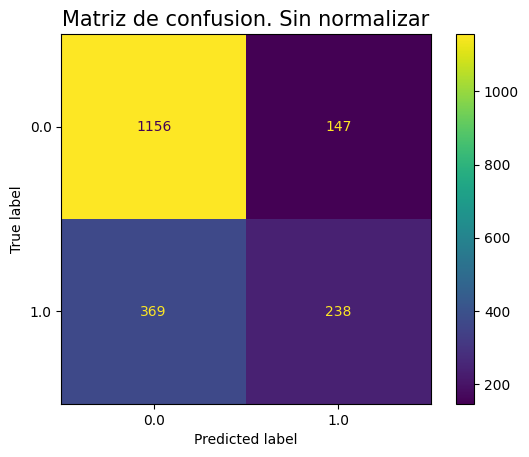

In [18]:
disp1 = metrics.ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test, normalize=None)
disp1.ax_.set_title('Matriz de confusion. Sin normalizar',{'fontsize':15})
plt.show()

In [19]:
print(metrics.classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

         0.0       0.76      0.89      0.82      1303
         1.0       0.62      0.39      0.48       607

    accuracy                           0.73      1910
   macro avg       0.69      0.64      0.65      1910
weighted avg       0.71      0.73      0.71      1910



Si quieres obtener los coeficientes del modelo:

In [20]:
np.round(logreg.coef_,4)

array([[ 0.1249,  1.0383,  1.2665,  1.0714,  1.6463,  2.0136,  0.3753,
         0.6273,  0.3319,  0.5494,  0.2733,  0.0863,  0.2019,  0.0396,
         0.0062, -0.0144, -0.2886, -0.6063, -1.4842, -2.2724, -0.4057,
        -0.7049, -1.3248, -0.0583,  0.1105, -0.0146]])